In [1]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


EPOCHS = 250
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
POINT_SHAPE = 2
MOMENTUM_SHAPE = 3
LATENT_DIMENSION = 16
D = 900


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
print(device)

cuda:0


## preprocess data and helper functionality

In [2]:
class SomeDataset(Dataset):
    def __init__(self, file):
        self.data = np.load(file)
        self.raw_images = self.data['EnergyDeposit']
        self.image = torch.Tensor(self.data['EnergyDeposit'].reshape(-1, 1, 30, 30))
        self.point = torch.Tensor(self.data['ParticlePoint'])
        self.momentum = torch.Tensor(self.data['ParticleMomentum'])

    def __len__(self):
        return len(self.image)
    
    def preprocess(self):
        n_data_img = []
        min_30 = np.min(self.raw_images, axis = 0)
        max_30 = np.max(self.raw_images, axis = 0)

        for i, elem in enumerate(self.raw_images):
            n_elem = (elem-min_30)/(max_30 - min_30)
            n_data_img.append(n_elem)
            if (i%5000 == 0):
                print (i)
        n_data_img = np.array(n_data_img)
        self.image = torch.Tensor(n_data_img.reshape(-1, 1, 30, 30))

    def __getitem__(self, i):
        return {
            "image": self.image[i],
            "point": self.point[i],
            "momentum": self.momentum[i]
        }

    
dataset = SomeDataset('./EgorWGAN/real_data.npz')

In [3]:
dataset.preprocess()

0
5000
10000
15000
20000
25000


show


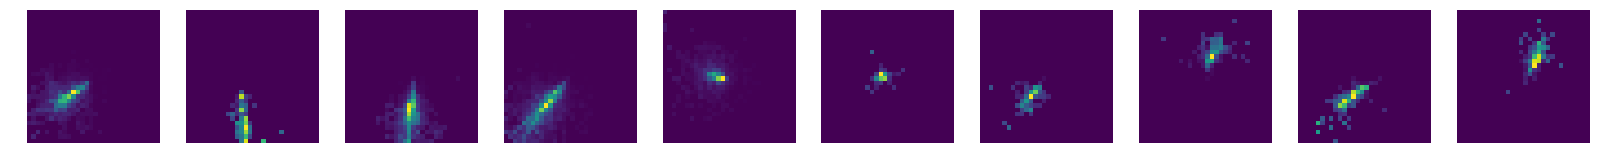

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(image, point, momentum):
    print ("show")
    image = image.cpu()
    point = point.cpu()
    momentum = momentum.cpu()
    plt.figure(figsize=(28, 28 / 10 * (image.shape[0] // 10 + 1)))
    image = image.view(-1, 30, 30)
    for i in range(image.shape[0]):
        plt.subplot(image.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(image.data[i].numpy())
        # plt.title("%1.3f %1.3f %1.3f" %(point.data[i].numpy(), momentum.data[i].numpy()))
        plt.axis('off')
    plt.show()
    
show_images(dataset[20:30]["image"], dataset[20:30]["point"], dataset[20:30]["momentum"])

## losses terms

In [5]:
import math

def reconstruction_loss_gauss(x_true_object, mu_generative_distr, log_sigma_var, reduce = 'sum'):
    x_true_object = x_true_object.reshape(x_true_object.shape[0], 900)
    x_prec = torch.exp(-log_sigma_var)
    x_diff = x_true_object - mu_generative_distr
    x_power = (x_diff * x_diff) * x_prec * -0.5
    loss = (log_sigma_var + math.log(2 * math.pi)) / 2 - x_power
    if reduce == 'sum':
        return torch.mean(loss)
    return loss


def kl(mean, ln_var, reduce='sum'):
    var = torch.exp(ln_var)
    mean_square = mean * mean
    loss = (mean_square + var - ln_var - 1) * 0.5
    if reduce == 'sum':
        return torch.sum(loss)
    else:
        return loss

## Conditional VAE

In [6]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(6, 128, 5, 1, 0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, 5, 2, 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 3, 1, 0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 8, 4, 2, 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 1, 3, 1, 0, bias=False),
            nn.ReLU()
        )
        self.latent_mu = nn.Sequential(
            nn.Linear(LATENT_DIMENSION, LATENT_DIMENSION)
        )
        self.latent_sigma = nn.Sequential(
            nn.Linear(LATENT_DIMENSION, LATENT_DIMENSION),
            nn.Softplus()
        )
        
        self.deconvolution = nn.Sequential(
            nn.ConvTranspose2d(6, 256, 3, 1, 0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 5, 1, 0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 8, 4, 1, 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 1, 6, 2, 0, bias=False),
            nn.ReLU()
        )
        self.generative_mu = nn.Sequential(nn.Linear(900, D))
        self.generative_sigma = nn.Sequential(nn.Linear(900, D), nn.Softplus())
    
    def forward_proposal(self, image, point, momentum):
        image = image.view(image.shape[0], 1, 30, 30)
        point = point.view(point.shape[0], POINT_SHAPE, 1, 1)
        a = point.expand(point.shape[0], POINT_SHAPE, 30, 30)
        moments = momentum.view(momentum.shape[0], MOMENTUM_SHAPE, 1, 1)
        b = moments.expand(momentum.shape[0], MOMENTUM_SHAPE, 30, 30)
        network_input = torch.cat([image, a, b], dim=1)
        x = self.convolution(network_input)
        x = x.view(x.shape[0], LATENT_DIMENSION)
        mu = self.latent_mu(x)
        sigma = self.latent_sigma(x)
        return mu, sigma
    
    def forward_generative(self, point, momentum, latent):
        
        latent = latent.view(latent.shape[0], 1, 4, 4)
        point = point.view(point.shape[0], POINT_SHAPE, 1, 1)
        a = point.expand(point.shape[0], POINT_SHAPE, 4, 4)
        moments = momentum.view(momentum.shape[0], MOMENTUM_SHAPE, 1, 1)
        b = moments.expand(momentum.shape[0], MOMENTUM_SHAPE, 4, 4)
        network_input = torch.cat([latent, a, b], dim=1)
        x = self.deconvolution(network_input)
        x = x.view(x.shape[0], D)
        mu = self.generative_mu(x)
        sigma = self.generative_sigma(x)
        return mu, sigma
    
    def sample_latent_distribution(self, mu, sigma):
        return torch.distributions.normal.Normal(mu, sigma).sample()
    
    def sample_prior_distribution(self, n):
        mu = torch.Tensor(n, LATENT_DIMENSION).fill_(0).to(device)
        sigma = torch.Tensor(n, LATENT_DIMENSION).fill_(1).to(device)
        return torch.distributions.normal.Normal(mu, sigma).sample()
    
    def sample_generative_distribution(self, mu, sigma):
        return torch.distributions.normal.Normal(mu, sigma).sample()
    
    def batch_loss(self, image, point, momentum, isShow):
        latent_mu, latent_sigma = self.forward_proposal(image, point, momentum)
        latent_sample = self.sample_latent_distribution(latent_mu, latent_sigma)
        generative_mu, generative_sigma = self.forward_generative(point, momentum, latent_sample)
        generative_sample = self.sample_generative_distribution(generative_mu, generative_sigma)
        
        rec_loss = reconstruction_loss_gauss(image, generative_mu, generative_sigma)
        kl_loss = kl(latent_mu, latent_sigma)
        if (isShow):
            show_images()
            
        
        return kl_loss + rec_loss, rec_loss, kl
    
    def generate_sample(self, point, momentum):
        prior_sample = self.sample_prior_distribution(point.shape[0])
        generative_mu, generative_sigma = self.forward_generative(point.to(device), momentum.to(device), prior_sample.to(device))
        generative_sample = self.sample_generative_distribution(generative_mu, generative_sigma)
        return generative_sample
        

def train(model, dataset):
    model.double()
    model.to(device)
    #dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        print(epoch)
        running_loss = 0
        dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
        for batch_id, data in enumerate(dataloader):
            image = data["image"].to(device)
            point = data["point"].to(device)
            momentum = data["momentum"].to(device)

            optimizer.zero_grad()
            if batch_id + 1 % 100 == 0:
                loss = model.batch_loss(image, point, momentum, True)
            else:
                loss = model.batch_loss(image, point, momentum, False)
            loss[0].backward()
            running_loss += loss[0]

            optimizer.step()
            
        print("Loss, NLL, KL ", running_loss, loss[1], loss[2])
        running_loss = 0
        samples = model.generate_sample(dataset[20:30]["point"], dataset[20:30]["momentum"])
        show_images(samples, dataset[20:30]["point"], dataset[20:30]["momentum"])


0
Loss, NLL, KL  tensor(4245.4845, grad_fn=<ThAddBackward>) tensor(0.9193, grad_fn=<MeanBackward1>) <function kl at 0x7f6a7c033510>
show


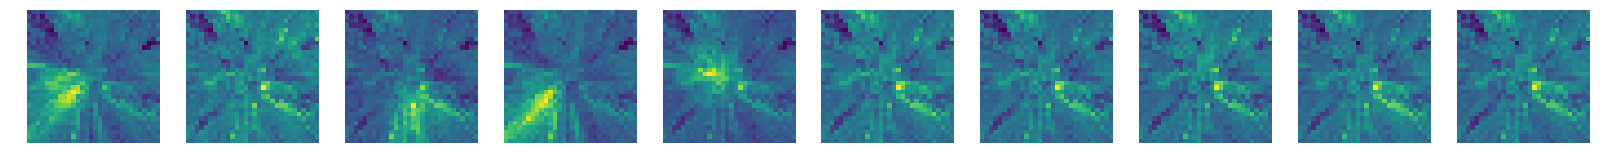

1
Loss, NLL, KL  tensor(1705.0269, grad_fn=<ThAddBackward>) tensor(0.9193, grad_fn=<MeanBackward1>) <function kl at 0x7f6a7c033510>
show


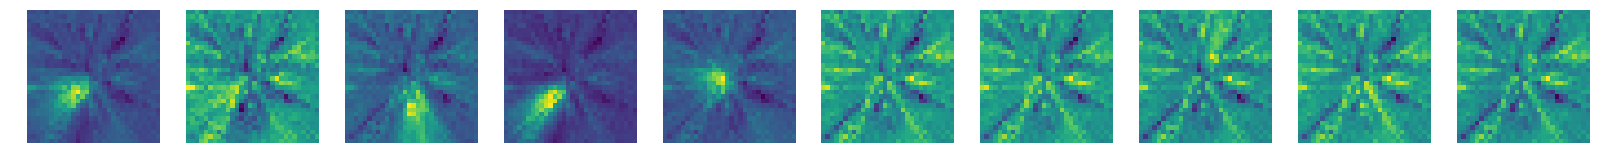

2
Loss, NLL, KL  tensor(1702.6829, grad_fn=<ThAddBackward>) tensor(0.9191, grad_fn=<MeanBackward1>) <function kl at 0x7f6a7c033510>
show


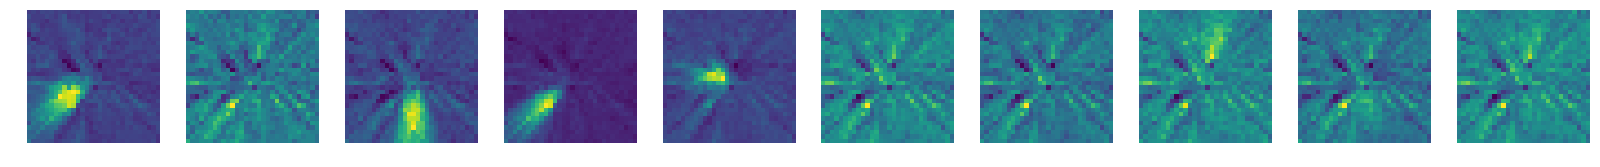

3
Loss, NLL, KL  tensor(1701.7797, grad_fn=<ThAddBackward>) tensor(0.9190, grad_fn=<MeanBackward1>) <function kl at 0x7f6a7c033510>
show


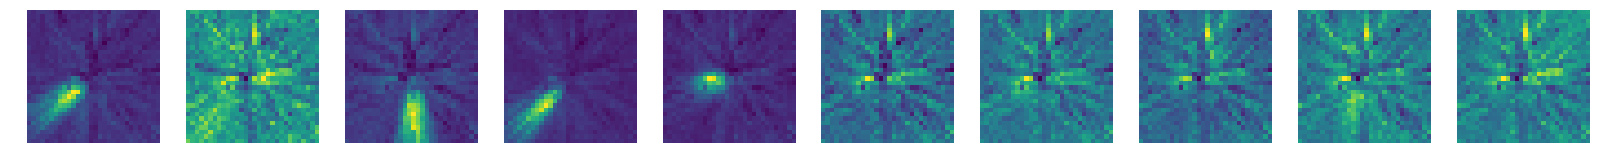

4
Loss, NLL, KL  tensor(1701.7103, grad_fn=<ThAddBackward>) tensor(0.9191, grad_fn=<MeanBackward1>) <function kl at 0x7f6a7c033510>
show


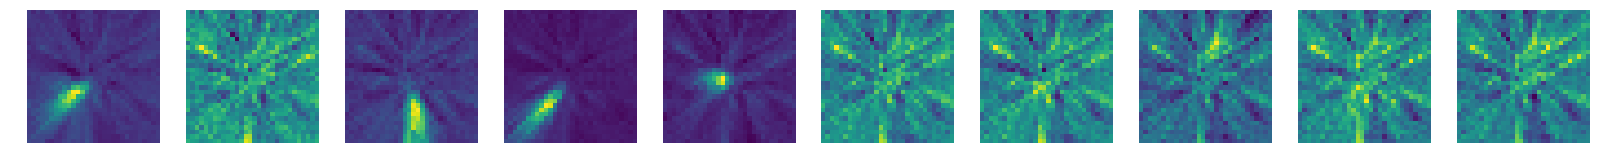

5


In [ ]:
cvae = CVAE()
train(cvae, dataset)

In [16]:
!pwd

/home/sayankotor


show


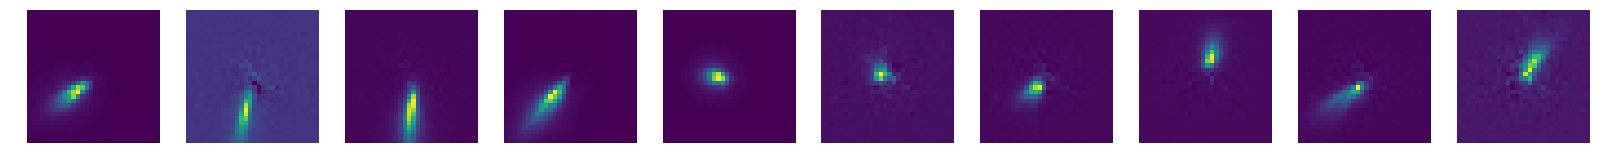

In [21]:
samples = cvae.generate_sample(dataset[20:30]["point"], dataset[20:30]["momentum"])
show_images(samples, dataset[20:30]["point"], dataset[20:30]["momentum"])